<a href="https://colab.research.google.com/github/quimHM/ML_assignment2/blob/main/MAB_sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#https://towardsdatascience.com/multi-armed-bandits-and-reinforcement-learning-dc9001dcb8da
#https://towardsdatascience.com/the-upper-confidence-bound-ucb-bandit-algorithm-c05c2bf4c13f

#https://github.com/WhatIThinkAbout/BabyRobot/tree/master/Multi_Armed_Bandits

In [4]:
# import modules 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import math
import random
%matplotlib inline

In [4]:
class PowerSocket:
    """ the base power socket class """
    
    def __init__(self, q, cl, var=0.1):                
        self.q = q        # the true reward value 
        self.confidence_level = cl          
        self.var = var   
        self.initialize() # reset the socket
        
    def initialize(self):
        self.Q = 0   # the estimate of this socket's reward value                
        self.n = 0   # the number of times this socket has been tried        
    
    def charge(self):
        """ return a random amount of charge """
        
        # the reward is a guassian distribution with unit variance around the true
        # value 'q'
        value = self.var * np.random.randn() + self.q        
        
        # never allow a charge less than 0 to be returned        
        return 0 if value < 0 else value
               
    def update(self,R):
        """ update this socket after it has returned reward value 'R' """     
    
        # increment the number of times this socket has been tried
        self.n += 1

        # the new estimate of the mean is calculated from the old estimate
        self.Q = (1 - 1.0/self.n) * self.Q + (1.0/self.n) * R

    def uncertainty(self, t): 
        """ calculate the uncertainty in the estimate of this socket's mean """
        if self.n == 0: return float('inf')                         
        return self.confidence_level * (np.sqrt(np.log(t) / self.n))         
        
    def sample(self,t):
        """ the UCB reward is the estimate of the mean reward plus its uncertainty """
        #print(self.uncertainty(t))
        return self.Q + self.uncertainty(t) 

In [3]:
class PowerSocketProb:
    """ the base power socket class """
    
    def __init__(self, q, cl):                
        self.q = q        # the true reward value 
        self.confidence_level = cl  
        self.initialize() # reset the socket
        
    def initialize(self):
        self.Q = 0   # the estimate of this socket's reward value                
        self.n = 0   # the number of times this socket has been tried        
    
    def charge(self):
        """ return a random amount of charge """
        
        # the reward is a guassian distribution with unit variance around the true
        # value 'q'
        value = 100 * np.random.binomial(1,self.q)     
        
        # never allow a charge less than 0 to be returned        
        return 0 if value < 0 else value
               
    def update(self,R):
        """ update this socket after it has returned reward value 'R' """     
    
        # increment the number of times this socket has been tried
        self.n += 1

        # the new estimate of the mean is calculated from the old estimate
        self.Q = (1 - 1.0/self.n) * self.Q + (1.0/self.n) * R

    def uncertainty(self, t): 
        """ calculate the uncertainty in the estimate of this socket's mean """
        if self.n == 0: return float('inf')                         
        return self.confidence_level * (np.sqrt(np.log(t) / self.n))         
        
    def sample(self,t):
        """ the UCB reward is the estimate of the mean reward plus its uncertainty """
        #print(self.uncertainty(t))
        return self.Q + self.uncertainty(t) 

In [2]:
# return the index of the largest value in the supplied list
# - arbitrarily select between the largest values in the case of a tie
# (the standard np.argmax just chooses the first value in the case of a tie)
def random_argmax(value_list):
  """ a random tie-breaking argmax"""
  values = np.asarray(value_list)
  return np.argmax(np.random.random(values.shape) * (values==values.max()))

# return the index of the smallest value in the supplied list
# - arbitrarily select between the smallest values in the case of a tie
# (the standard np.argmin just chooses the first value in the case of a tie)
def random_argmin(value_list):
  """ a random tie-breaking argmin"""
  values = np.asarray(value_list)
  return np.argmin(np.random.random(values.shape) * (values==values.min()))


In [7]:
class SocketTester():
    """ create and test a set of sockets over a single test run """

    def __init__(self, socket, socket_order, socket_vars, confidence_level):  
        
        # create supplied socket type with a mean value defined by socket order 
        # self.sockets = [socket(q, confidence_level) for q in socket_order]     
        self.sockets = [socket(socket_order[s], confidence_level, socket_vars[s]) for s in range(len(socket_order))]

        # set the number of sockets equal to the number created
        self.number_of_sockets = len(self.sockets)

        self.number_of_stats = 2                 
            
    def initialize_run(self, number_of_steps):
        """ reset counters at the start of a run """
        
        # save the number of steps over which the run will take place
        self.number_of_steps = number_of_steps
        
        # reset the actual number of steps that the test ran for
        self.total_steps = 0
        
        # monitor the total reward obtained over the run
        self.total_reward = 0
        
        # the current total reward at each timestep of the run
        self.total_reward_per_timestep = []
        
        # the actual reward obtained at each timestep
        self.reward_per_timestep = []
           
        # stats for each time-step
        # - by default records: estimate, number of trials
        self.socket_stats = np.zeros(shape=(number_of_steps+1, 
                                            self.number_of_sockets, 
                                            self.number_of_stats))
        
        # ensure that all sockets are re-initialized
        for socket in self.sockets: socket.initialize()
            
                                
    def charge_and_update(self,socket_index):
        """ charge from & update the specified socket and associated parameters """
        
        # charge from the chosen socket and update its mean reward value
        reward = self.sockets[socket_index].charge()
        self.sockets[socket_index].update(reward)

        # update the total reward
        self.total_reward += reward   
        
        # store the current total reward at this timestep
        self.total_reward_per_timestep.append(self.total_reward)
        
        # store the reward obtained at this timestep
        self.reward_per_timestep.append(reward)        
        
        
    def get_socket_stats( self, t ):
        """ get the current information from each socket """        
        socket_stats = [[socket.Q, socket.n] for socket in self.sockets]
        return socket_stats     
    
    def get_mean_reward( self ):
        """ the total reward averaged over the number of time steps """
        return (self.total_reward/self.total_steps)
    
    def get_total_reward_per_timestep( self ):
        """ the cumulative total reward at each timestep of the run """
        return self.total_reward_per_timestep
    
    def get_reward_per_timestep( self ):
        """ the actual reward obtained at each timestep of the run """
        return self.reward_per_timestep
    
    def get_estimates(self):
        """ get the estimate of each socket's reward at each timestep of the run """
        return self.socket_stats[:,:,0]  
    
    def get_number_of_trials(self):
        """ get the number of trials of each socket at each timestep of the run """
        return self.socket_stats[:,:,1]          
                
    def get_socket_percentages( self ):
        """ get the percentage of times each socket was tried over the run """
        return (self.socket_stats[:,:,1][self.total_steps]/self.total_steps)        
    
    def get_time_steps( self ):
        """ get the number of time steps that the test ran for """
        return self.total_steps
    
    def select_socket( self, t ):
        """ Greedy Socket Selection"""
        
        # choose the socket with the current highest mean reward or arbitrarily
        # select a socket in the case of a tie            
        socket_index = random_argmax([socket.sample(t+1) for socket in self.sockets]) 
        return socket_index     
    
    
    def run( self, number_of_steps, maximum_total_reward = float('inf')):  
        """ perform a single run, over the set of sockets, 
            for the defined number of steps """
        
        # reset the run counters
        self.initialize_run(number_of_steps)
        
        # loop for the specified number of time-steps
        for t in range(number_of_steps):

            # get information about all sockets at the start of the time step
            self.socket_stats[t] = self.get_socket_stats(t)            
            
            # select a socket
            socket_index = self.select_socket(t)
            
            # charge from the chosen socket and update its mean reward value
            self.charge_and_update(socket_index)
            
            # test if the accumulated total reward is greater than the maximum
            if self.total_reward > maximum_total_reward:
                break
       
        # save the actual number of steps that have been run
        self.total_steps = t    
    
        # get the stats for each socket at the end of the run        
        self.socket_stats[t+1] = self.get_socket_stats(t+1)           
        
        return self.total_steps, self.total_reward
  

In [8]:
def mus_and_devs_random():
  devs = []
  mus = []
  for i in range(8):
    d = round(random.uniform(5.0,15.0),2)
    m = round(random.uniform(70.0,100.0),2)
    devs.append(d)
    mus.append(m)
  return mus,devs

In [9]:
def mus_and_devs():
  devs = [10.0]*8
  mus = []
  for i in range(8):
    m = 100.0-i*5.0
    mus.append(m)
  return mus,devs

In [10]:
#mus,devs = mus_and_devs_random()
mus,devs = mus_and_devs()

#devs = [9.3, 5.67, 11.93, 9.18, 13.66, 8.94, 6.83, 7.91]
#mus = [92.1, 98.48, 88.49, 80.36, 89.97, 73.78, 97.18, 91.52]

print(devs)
print(mus)
test = SocketTester(PowerSocket, mus, devs, 5)
test.run(1000)
test.get_number_of_trials()[-1]

[10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
[100.0, 95.0, 90.0, 85.0, 80.0, 75.0, 70.0, 65.0]


array([969.,  24.,   1.,   1.,   1.,   1.,   2.,   1.])

In [11]:
class SocketTesterBatch():
    """ create and test a set of sockets over a single test run """

    def __init__(self, socket, socket_order, socket_vars, confidence_level):  
        
        # create supplied socket type with a mean value defined by socket order 
        self.sockets = [socket(socket_order[s], confidence_level, socket_vars[s]) for s in range(len(socket_order))]
        
        # set the number of sockets equal to the number created
        self.number_of_sockets = len(self.sockets)

        self.number_of_stats = 2                 
            
    def initialize_run(self, number_of_steps):
        """ reset counters at the start of a run """
        
        # save the number of steps over which the run will take place
        self.number_of_steps = number_of_steps
        
        # reset the actual number of steps that the test ran for
        self.total_steps = 0
        
        # monitor the total reward obtained over the run
        self.total_reward = 0
        
        # the current total reward at each timestep of the run
        self.total_reward_per_timestep = []
        
        # the actual reward obtained at each timestep
        self.reward_per_timestep = []
           
        # stats for each time-step
        # - by default records: estimate, number of trials
        self.socket_stats = np.zeros(shape=(number_of_steps+1, 
                                            self.number_of_sockets, 
                                            self.number_of_stats))
        
        # ensure that all sockets are re-initialized
        for socket in self.sockets: socket.initialize()
            
                                
    def charge_and_update(self,socket_index):
        """ charge from & update the specified socket and associated parameters """
        
        # charge from the chosen socket and update its mean reward value
        reward = self.sockets[socket_index].charge()
        self.sockets[socket_index].update(reward)

        # update the total reward
        self.total_reward += reward   
        
        # store the current total reward at this timestep
        self.total_reward_per_timestep.append(self.total_reward)
        
        # store the reward obtained at this timestep
        self.reward_per_timestep.append(reward)        
        
        
    def get_socket_stats( self, t ):
        """ get the current information from each socket """        
        socket_stats = [[socket.Q, socket.n] for socket in self.sockets]
        return socket_stats     
    
    def get_mean_reward( self ):
        """ the total reward averaged over the number of time steps """
        return (self.total_reward/self.total_steps)
    
    def get_total_reward_per_timestep( self ):
        """ the cumulative total reward at each timestep of the run """
        return self.total_reward_per_timestep
    
    def get_reward_per_timestep( self ):
        """ the actual reward obtained at each timestep of the run """
        return self.reward_per_timestep
    
    def get_estimates(self):
        """ get the estimate of each socket's reward at each timestep of the run """
        return self.socket_stats[:,:,0]  
    
    def get_number_of_trials(self):
        """ get the number of trials of each socket at each timestep of the run """
        return self.socket_stats[:,:,1]          
                
    def get_socket_percentages( self ):
        """ get the percentage of times each socket was tried over the run """
        return (self.socket_stats[:,:,1][self.total_steps]/self.total_steps)        
    
    def get_time_steps( self ):
        """ get the number of time steps that the test ran for """
        return self.total_steps
    
    def select_socket( self, t ):
        """ Greedy Socket Selection"""
        
        # choose the socket with the current highest mean reward or arbitrarily
        # select a socket in the case of a tie            
        mask = [self.get_number_of_trials()[t][i]<self.possibles[i] for i in range(len(self.sockets))]
        #print(mask)
        available = [self.sockets[i] for i in range(len(self.sockets)) if (mask[i])]
        socket_max = random_argmax([socket.sample(t+1) for socket in available]) 
        #print(socket_max)
        socket_index = self.sockets.index(available[socket_max])
        return socket_index     
    
    def return_increments(self, decisions_to_consider):
        presence = np.array([i/len(decisions_to_consider) for i in self.possibles])
        selected_presence = np.array(self.get_socket_percentages())
        diff = np.subtract(selected_presence, presence)
        diff = np.divide(diff,presence, out=np.zeros_like(selected_presence), where=presence!=0)
        #print(diff)
        #print(diff.sum())
        return diff
    
    def run( self, decisions_to_consider, max_percent_decisions=1, prints_bool = True):  
        """ perform a single run, over the set of sockets, 
            for the defined number of steps """
        
        # reset the run counters
        self.initialize_run(len(decisions_to_consider))

        self.possibles = [0]*8 #TODO: DEPENDS ON N OF CLUSTER (DECISIONS.UNIQUE() ISNT ENOUGH BECAUSE IT CAN LACK SOME INSTANCES)
        for i in np.unique(np.array(decisions_to_consider)):
          self.possibles[i] = decisions_to_consider.count(i) 

        usos = 0
        usos_maxims = math.floor(max_percent_decisions*len(decisions_to_consider))
        #print(usos_maxims)

        # loop for the specified number of time-steps
        for t in range(len(decisions_to_consider)):

            # get information about all sockets at the start of the time step
            self.socket_stats[t] = self.get_socket_stats(t)            
            
            # select a socket
            socket_index = self.select_socket(t)
            #if(decisions_to_consider[t]==socket_index):
            if(self.get_number_of_trials()[t][socket_index]<self.possibles[socket_index]):
              # charge from the chosen socket and update its mean reward value
              self.charge_and_update(socket_index)
              usos+=1
              
              if usos > usos_maxims:
                  #print(usos,usos_maxims)
                  break
        # save the actual number of steps that have been run
        self.total_steps = t    
    
        # get the stats for each socket at the end of the run        
        self.socket_stats[t+1] = self.get_socket_stats(t+1)           
        
        if(prints_bool):
          print("Reward distribution:",[s.q for s in self.sockets])
          #print("Intances of each cluster:",self.possibles)
          print("Presence of each in batch (%):",[100*i/len(decisions_to_consider) for i in self.possibles])
          #print("Times selected:",self.get_number_of_trials()[t])
          print("Relative approval rate (%):",[round(100*self.get_number_of_trials()[t][i]/self.possibles[i],2) if self.possibles[i]>0.0 else 0.0 for i in range(len(self.possibles))])
          print("Percentage over total selected (%):",[round(100*p,2) for p in self.get_socket_percentages()])
          #print("For a total reward:",self.total_reward)


        return self.total_steps, self.total_reward, self.return_increments(decisions_to_consider)
  

In [12]:
devs = [9.3, 5.67, 11.93, 9.18, 13.66, 8.94, 6.83, 7.91]
mus = [92.1, 98.48, 88.49, 80.36, 89.97, 73.78, 97.18, 91.52]
#mus,devs = mus_and_devs()
test2 = SocketTesterBatch(PowerSocket, mus, devs, 10)

decisions = random.choices(range(8), k=1000)
decisions = []
for i in range(8):
  for j in range(125):
    decisions.append(i)
#decisions = [[125]]*8
ts,tr,_ = test2.run(decisions)

Reward distribution: [92.1, 98.48, 88.49, 80.36, 89.97, 73.78, 97.18, 91.52]
Presence of each in batch (%): [12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5]
Relative approval rate (%): [100.0, 100.0, 100.0, 100.0, 100.0, 99.2, 100.0, 100.0]
Percentage over total selected (%): [12.51, 12.51, 12.51, 12.51, 12.51, 12.41, 12.51, 12.51]


In [13]:
ts,tr,_ = test2.run(decisions, 0.5)

Reward distribution: [92.1, 98.48, 88.49, 80.36, 89.97, 73.78, 97.18, 91.52]
Presence of each in batch (%): [12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5]
Relative approval rate (%): [100.0, 100.0, 0.8, 3.2, 72.8, 2.4, 100.0, 20.8]
Percentage over total selected (%): [25.0, 25.0, 0.2, 0.8, 18.2, 0.6, 25.0, 5.2]


In [14]:
#sample_bias = [0.555, 0.24, 0.023, 0.011, 0.087, 0.081, 0.001, 0.001]
#devs = [9.3, 5.67, 11.93, 9.18, 13.66, 8.94, 6.83, 7.91]
#mus = [92.1, 98.48, 88.49, 80.36, 89.97, 73.78, 97.18, 91.52]
weights_m = []
for m in mus:
  weights_m.append((m*m*m*m*m*m*m*m*m)/1000*(m*m*m*m*m*m*m*m*m)/1000)
sample_bias_decisions = random.choices(range(8),weights=weights_m,k=1000)
print(sample_bias_decisions)
ts,tr,_ = test2.run(sample_bias_decisions, 0.8)

[6, 7, 7, 1, 6, 1, 1, 6, 1, 1, 0, 6, 7, 6, 4, 7, 1, 0, 6, 4, 6, 3, 0, 6, 1, 6, 0, 1, 6, 6, 0, 1, 1, 0, 0, 0, 2, 2, 0, 1, 1, 7, 0, 6, 1, 6, 1, 1, 1, 2, 6, 6, 0, 0, 6, 6, 1, 2, 1, 6, 6, 7, 6, 1, 1, 6, 6, 4, 7, 1, 6, 2, 4, 7, 6, 2, 6, 0, 6, 1, 3, 6, 1, 2, 7, 1, 1, 1, 0, 2, 1, 1, 4, 6, 7, 0, 6, 1, 2, 6, 1, 4, 7, 6, 1, 1, 6, 2, 0, 1, 0, 1, 6, 4, 1, 6, 6, 4, 1, 6, 4, 7, 6, 1, 0, 2, 1, 1, 6, 2, 1, 1, 6, 6, 2, 4, 2, 1, 1, 1, 2, 0, 7, 4, 7, 1, 0, 7, 1, 1, 1, 6, 6, 1, 7, 6, 4, 1, 6, 6, 4, 1, 1, 0, 7, 6, 6, 0, 1, 1, 4, 2, 2, 1, 2, 1, 7, 6, 1, 1, 4, 7, 6, 0, 6, 0, 1, 4, 4, 4, 4, 0, 1, 6, 6, 3, 7, 1, 4, 4, 4, 7, 6, 1, 3, 1, 2, 0, 0, 6, 1, 1, 1, 6, 6, 4, 1, 6, 7, 0, 1, 6, 1, 1, 7, 7, 7, 1, 6, 1, 0, 6, 1, 4, 7, 7, 0, 6, 6, 2, 1, 1, 0, 7, 6, 0, 1, 1, 0, 1, 2, 6, 6, 4, 7, 6, 0, 6, 1, 6, 0, 7, 1, 4, 1, 6, 2, 4, 1, 7, 1, 7, 1, 0, 1, 1, 2, 2, 6, 2, 1, 6, 7, 7, 1, 6, 1, 7, 1, 0, 1, 6, 2, 1, 7, 1, 6, 6, 1, 6, 1, 7, 1, 2, 0, 1, 6, 6, 6, 1, 7, 6, 1, 2, 6, 6, 1, 6, 6, 1, 0, 1, 6, 6, 6, 7, 1, 6, 6, 2, 6, 0, 6, 

In [15]:
a=np.array([9.7, 36.7, 5.6, 0.9, 7.2, 0.1, 29.3, 10.5])
#b=np.array([12.12, 45.88, 2.0, 1.12, 0.25, 0.12, 36.62, 1.88])
b=np.array([12.12, 45.88, 0.75, 0.25, 1.38, 0.12, 36.62, 2.88])


diff = np.subtract(b,a)
print(diff)
diff = np.divide(diff,a)
print(diff)

[ 2.42  9.18 -4.85 -0.65 -5.82  0.02  7.32 -7.62]
[ 0.24948454  0.25013624 -0.86607143 -0.72222222 -0.80833333  0.2
  0.24982935 -0.72571429]


###**NON-STATIC**

In [16]:
#def f(probs, val, ind):
#    probs[ind] += val
#    mask = np.ones(len(probs), bool)
#    mask[ind] = False
#    probs[mask] -= val / (len(probs) - 1)
#    return np.clip(probs, 0, np.infty) / np.sum(np.clip(probs, 0, np.infty))

In [17]:
def cummulative_sample(tester,iter,orig,coef):
  instances_distribution = np.array(orig)
  for i in range(iter):
    pbool=False
    if(i%math.ceil(iter/4)==0 or i==iter-1):
      print(i)
      #print(list(instances_distribution))
      pbool=True

    decisions = random.choices(range(8),weights=list(instances_distribution),k=5000)
    ts,tr,ti = tester.run(decisions, 0.8, pbool)
    
    #for i in range(len(ti)):
    #  instances_distribution = f(instances_distribution,ti[i],i)
    instances_distribution = np.add(instances_distribution,ti*coef*100)
    instances_distribution = np.clip(instances_distribution,0,None)
    instances_distribution = instances_distribution / instances_distribution.sum()

In [18]:
o_sample_bias = [0.555, 0.24, 0.023, 0.011, 0.087, 0.081, 0.001, 0.001]
#o_sample_bias = weights_m
cummulative_sample(test2,35,o_sample_bias,0.001)

0
Reward distribution: [92.1, 98.48, 88.49, 80.36, 89.97, 73.78, 97.18, 91.52]
Presence of each in batch (%): [55.66, 23.04, 2.22, 0.94, 9.34, 8.42, 0.22, 0.16]
Relative approval rate (%): [95.62, 100.0, 67.57, 8.51, 18.63, 0.48, 100.0, 100.0]
Percentage over total selected (%): [66.53, 28.8, 1.88, 0.1, 2.17, 0.05, 0.27, 0.2]
9
Reward distribution: [92.1, 98.48, 88.49, 80.36, 89.97, 73.78, 97.18, 91.52]
Presence of each in batch (%): [30.44, 40.32, 0.0, 0.0, 0.0, 0.0, 19.58, 9.66]
Relative approval rate (%): [58.41, 100.0, 0.0, 0.0, 0.0, 0.0, 100.0, 24.02]
Percentage over total selected (%): [22.22, 50.4, 0.0, 0.0, 0.0, 0.0, 24.48, 2.9]
18
Reward distribution: [92.1, 98.48, 88.49, 80.36, 89.97, 73.78, 97.18, 91.52]
Presence of each in batch (%): [0.0, 87.86, 0.0, 0.0, 0.0, 0.0, 12.14, 0.0]
Relative approval rate (%): [0.0, 84.34, 0.0, 0.0, 0.0, 0.0, 48.6, 0.0]
Percentage over total selected (%): [0.0, 92.62, 0.0, 0.0, 0.0, 0.0, 7.38, 0.0]
27
Reward distribution: [92.1, 98.48, 88.49, 80

In [19]:
no_sample_bias = [1/8]*8
cummulative_sample(test2,35,no_sample_bias,0.05)

0
Reward distribution: [92.1, 98.48, 88.49, 80.36, 89.97, 73.78, 97.18, 91.52]
Presence of each in batch (%): [12.56, 12.4, 12.2, 12.88, 11.98, 12.44, 12.38, 13.16]
Relative approval rate (%): [100.0, 100.0, 100.0, 36.49, 100.0, 4.98, 100.0, 100.0]
Percentage over total selected (%): [15.7, 15.5, 15.25, 5.88, 14.98, 0.78, 15.48, 16.45]
9
Reward distribution: [92.1, 98.48, 88.49, 80.36, 89.97, 73.78, 97.18, 91.52]
Presence of each in batch (%): [0.0, 100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Relative approval rate (%): [0.0, 80.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Percentage over total selected (%): [0.0, 100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
18
Reward distribution: [92.1, 98.48, 88.49, 80.36, 89.97, 73.78, 97.18, 91.52]
Presence of each in batch (%): [0.0, 100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Relative approval rate (%): [0.0, 80.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Percentage over total selected (%): [0.0, 100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


KeyboardInterrupt: ignored

In [ ]:
no_sample_bias = [1/8]*8
cummulative_sample(test2,150,no_sample_bias,0.05)

In [20]:
def nonstatic(iter, rewards_d_o_mu, rewards_d_o_dev, r_coef, instances_d_o, i_coef):
  rewards_d = np.array(rewards_d_o_mu)
  instances_d = np.array(instances_d_o)

  #iter = 1000
  for i in range(iter):
    pbool=False
    if(i%math.ceil(iter/4)==0 or i==iter-1):
        print(i)
        #print(list(instances_distribution))
        pbool=True

    updated_test = SocketTesterBatch(PowerSocket, list(rewards_d), rewards_d_o_dev, 10)
    decisions = random.choices(range(8),weights=list(instances_d),k=5000)
    ts,tr,ti = updated_test.run(decisions, 0.8, pbool)

    increments = ti
    #increments = np.subtract(np.array(updated_test.get_socket_percentages()),0.5)
    #print(increments)

    rewards_d = np.add(rewards_d,increments*r_coef*100)
    rewards_d = np.clip(rewards_d,0,100)
    #print(rewards_d)

    instances_d = np.add(instances_d,increments*i_coef)
    instances_d = np.clip(instances_d,0,None)
    instances_d = instances_d / instances_d.sum()

In [ ]:
#nonstatic(500, rewards_bias, devs_nonbias, 0.001, instances_bias, 0.001)

In [ ]:
#nonstatic(2500, rewards_nonbias, 0, instances_bias, 0.01)

In [ ]:
#nonstatic(100, rewards_bias, 0, instances_nonbias, 0)

In [ ]:
#nonstatic(100, rewards_bias, 0.1, instances_nonbias, 0)

In [ ]:
#nonstatic(100, rewards_bias, 0, instances_bias, 0.01)

In [ ]:
#nonstatic(100, rewards_bias, 0.01, instances_bias, 0)

In [ ]:
nonstatic(100, rewards_bias, 0.01, instances_bias, 0.01)

###**SOLUTION?**

In [21]:
class SocketTesterBatchSOLUTION():
    """ create and test a set of sockets over a single test run """

    def __init__(self, socket, socket_order, socket_vars, confidence_level, sub_opt):  
        
        self.subopt_coef = sub_opt

        # create supplied socket type with a mean value defined by socket order 
        self.sockets = [socket(socket_order[s], confidence_level, socket_vars[s]) for s in range(len(socket_order))]
        
        # set the number of sockets equal to the number created
        self.number_of_sockets = len(self.sockets)

        self.number_of_stats = 2                 
            
    def initialize_run(self, number_of_steps):
        """ reset counters at the start of a run """
        
        # save the number of steps over which the run will take place
        self.number_of_steps = number_of_steps
        
        # reset the actual number of steps that the test ran for
        self.total_steps = 0
        
        # monitor the total reward obtained over the run
        self.total_reward = 0
        
        # the current total reward at each timestep of the run
        self.total_reward_per_timestep = []
        
        # the actual reward obtained at each timestep
        self.reward_per_timestep = []
           
        # stats for each time-step
        # - by default records: estimate, number of trials
        self.socket_stats = np.zeros(shape=(number_of_steps+1, 
                                            self.number_of_sockets, 
                                            self.number_of_stats))
        
        # ensure that all sockets are re-initialized
        for socket in self.sockets: socket.initialize()
            
                                
    def charge_and_update(self,socket_index):
        """ charge from & update the specified socket and associated parameters """
        
        # charge from the chosen socket and update its mean reward value
        reward = self.sockets[socket_index].charge()
        self.sockets[socket_index].update(reward)

        # update the total reward
        self.total_reward += reward   
        
        # store the current total reward at this timestep
        self.total_reward_per_timestep.append(self.total_reward)
        
        # store the reward obtained at this timestep
        self.reward_per_timestep.append(reward)        
        
        
    def get_socket_stats( self, t ):
        """ get the current information from each socket """        
        socket_stats = [[socket.Q, socket.n] for socket in self.sockets]
        return socket_stats     
    
    def get_mean_reward( self ):
        """ the total reward averaged over the number of time steps """
        return (self.total_reward/self.total_steps)
    
    def get_total_reward_per_timestep( self ):
        """ the cumulative total reward at each timestep of the run """
        return self.total_reward_per_timestep
    
    def get_reward_per_timestep( self ):
        """ the actual reward obtained at each timestep of the run """
        return self.reward_per_timestep
    
    def get_estimates(self):
        """ get the estimate of each socket's reward at each timestep of the run """
        return self.socket_stats[:,:,0]  
    
    def get_number_of_trials(self):
        """ get the number of trials of each socket at each timestep of the run """
        return self.socket_stats[:,:,1]          
                
    def get_socket_percentages( self ):
        """ get the percentage of times each socket was tried over the run """
        return (self.socket_stats[:,:,1][self.total_steps]/self.total_steps)        
    
    def get_time_steps( self ):
        """ get the number of time steps that the test ran for """
        return self.total_steps
    
    def bias_presence_hipo(self, t):
        presence = np.array([i/sum(self.possibles) for i in self.possibles])
        bias_list = []
        for c in range(len(self.sockets)):
          pulled = self.socket_stats[:,:,1][t].copy()
          pulled[c]+=1
          selected_presence = np.array(pulled/(t+1))
          diff = np.subtract(selected_presence, presence)
          #diff = np.divide(diff,presence, out=np.zeros_like(selected_presence), where=presence!=0)
          abs = np.abs(diff)
          bias_list.append(np.sum(abs))
        #return random_argmin(bias_list)
        return bias_list

    def bias_presence_step(self, t):
        presence = np.array([i/sum(self.possibles) for i in self.possibles])
        selected_presence = np.array(self.socket_stats[:,:,1][t]/t)
        diff = np.subtract(selected_presence, presence)
        #diff = np.divide(diff,presence, out=np.zeros_like(selected_presence), where=presence!=0)
        abs = np.abs(diff)
        return np.sum(abs) 

    def final_bias_presence(self):
        presence = np.array([i/sum(self.possibles) for i in self.possibles])
        selected_presence = np.array(self.get_socket_percentages())
        diff = np.subtract(selected_presence, presence)
        abs = np.abs(diff)
        return np.sum(abs) 

    def bias_rate_hipo(self, t):
        bias_list = []
        for c in range(len(self.sockets)):
          pulled = self.socket_stats[:,:,1][t].copy()
          pulled[c]+=1
          curr_percentages = np.array([pulled[i]/self.possibles[i] for i in range(len(self.sockets))])
          overall_percentages = np.mean(curr_percentages)
          diff = np.subtract(overall_percentages,curr_percentages)
          abs = np.abs(diff)
          bias_list.append(np.sum(abs))
        #return random_argmin(bias_list)
        return bias_list

    def bias_rate_step(self, t):
        curr_percentages = np.array([self.get_number_of_trials()[t][i]/self.possibles[i] for i in range(len(self.sockets))])
        overall_percentages = np.mean(curr_percentages)
        diff = np.subtract(overall_percentages,curr_percentages)
        abs = np.abs(diff)
        return np.sum(abs) 

    def final_bias_rate(self):
        final_percentages = np.array([self.get_number_of_trials()[self.total_steps][i]/self.possibles[i] for i in range(len(self.sockets))])
        overall_percentages = self.capping #np.mean(curr_percentages)
        diff = np.subtract(overall_percentages,final_percentages)
        abs = np.abs(diff)
        return np.sum(abs) 
    """
    def select_socket( self, t ):
        #CONSTRAINT A
        curr_percentages = self.socket_stats[:,:,1][t]/t
        mean_percentages = self.capping #np.mean(curr_percentages)
        dif_percentages = np.subtract(mean_percentages,self.socket_stats[:,:,1][t]/t)

        #CONSTRAINT B
        mean_selections = np.mean(self.get_number_of_trials()[t])
        dif_selections = np.subtract(mean_selections,self.get_number_of_trials()[t])

        #DUES CONSTRAINTS, UNA PER PERCENTATGES, L'ALTRE n SELECTIONS
        #dif = dif_percentages #rang 10-30-50
        dif = dif_selections   #rang 0-0.01-0.1

        #print(dif)

        # choose the socket with the current highest mean reward or arbitrarily
        # select a socket in the case of a tie            
        mask = [self.get_number_of_trials()[t][i]<self.possibles[i] for i in range(len(self.sockets))]
        #print(mask)
        available_sockets = [self.sockets[s] for s in range(len(self.sockets)) if (mask[s])]
        available = [i for i in range(len(self.sockets)) if (mask[i])]

        socket_max = random_argmax([self.sockets[socket].sample(t+1)+self.subopt_coef*dif[socket] for socket in available]) 
        #socket_max = random_argmax([self.sockets[socket].sample(t+1) for socket in available]) 

        #print(socket_max)
        socket_index = self.sockets.index(available_sockets[socket_max])
        return socket_index
    """
    def select_socket( self, t ):
        """ Greedy Socket Selection"""
        mask = [self.get_number_of_trials()[t][i]<self.possibles[i] for i in range(len(self.sockets))]
        available_sockets = [self.sockets[s] for s in range(len(self.sockets)) if (mask[s])]
        available = [i for i in range(len(self.sockets)) if (mask[i])]

        socket_max = random_argmax([self.sockets[socket].sample(t+1) for socket in available]) 
        socket_max_index = self.sockets.index(available_sockets[socket_max])

        #print(self.bias_presence_hipo(t))
        socket_min = random_argmin([self.bias_presence_hipo(t)[socket] for socket in available]) 
        #print([self.bias_presence_hipo(t)[socket] for socket in available][socket_min])
        socket_min_index = self.sockets.index(available_sockets[socket_min])
        #print(self.bias_presence_hipo(t)[socket_min_index])

        return_index = random.choices([socket_min_index,socket_max_index],cum_weights=[self.subopt_coef,1])
        #print(socket_min_index,socket_max_index,"->",return_index[0])
        return return_index[0]     
    
    def return_increments(self, decisions_to_consider):
        presence = np.array([i/len(decisions_to_consider) for i in self.possibles])
        selected_presence = np.array(self.get_socket_percentages())
        diff = np.subtract(selected_presence, presence)
        diff = np.divide(diff,presence, out=np.zeros_like(diff), where=presence!=0)
        #print(diff)
        #print(diff.sum())
        return diff
    
    def run( self, decisions_to_consider, max_percent_decisions=1, prints_bool = True):  
        """ perform a single run, over the set of sockets, 
            for the defined number of steps """
        
        # reset the run counters
        self.initialize_run(len(decisions_to_consider))

        self.possibles = [0]*8 #TODO: DEPENDS ON N OF CLUSTER (DECISIONS.UNIQUE() ISNT ENOUGH BECAUSE IT CAN LACK SOME INSTANCES)
        for i in np.unique(np.array(decisions_to_consider)):
          self.possibles[i] = decisions_to_consider.count(i) 
        #print("possibles",self.possibles)

        usos = 0
        self.capping = max_percent_decisions
        usos_maxims = math.floor(max_percent_decisions*len(decisions_to_consider))
        #print(usos_maxims)

        # loop for the specified number of time-steps
        for t in range(1,len(decisions_to_consider)):

            # get information about all sockets at the start of the time step
            self.socket_stats[t] = self.get_socket_stats(t)            
            
            # select a socket
            socket_index = self.select_socket(t)
            #if(decisions_to_consider[t]==socket_index):
            if(self.get_number_of_trials()[t][socket_index]<self.possibles[socket_index]):
              # charge from the chosen socket and update its mean reward value
              self.charge_and_update(socket_index)
              usos+=1
              
              if usos > usos_maxims:
                  #print(usos,usos_maxims)
                  break
        # save the actual number of steps that have been run
        self.total_steps = t    
    
        # get the stats for each socket at the end of the run        
        self.socket_stats[t+1] = self.get_socket_stats(t+1)           
        
        self.approval_rates = [round(100*self.get_number_of_trials()[t][i]/self.possibles[i],2) if self.possibles[i]>0.0 else 0.0 for i in range(len(self.possibles))]
        if(prints_bool):
          #print("possibles",self.possibles)
          print("Reward distribution:",[round(s.q,2) for s in self.sockets])
          #print("Intances of each cluster:",self.possibles)
          print("Presence of each in batch (%):",[100*i/len(decisions_to_consider) for i in self.possibles])
          #print("Times selected:",self.get_number_of_trials()[t])
          print("Relative approval rate (%):",self.approval_rates)
          print("Percentage over total selected (%):",[round(100*p,2) for p in self.get_socket_percentages()])
          print("Total reward:",self.total_reward,"|| and presence bias:",self.final_bias_presence())
          #print("For a total reward:",self.total_reward)
          #print(self.return_increments(decisions_to_consider))
        return_dic = {
            "total_steps":self.total_steps,
            "total_reward":self.total_reward,
            "increments":self.return_increments(decisions_to_consider),
            "bias_presence":self.final_bias_presence(),
            "percentages":self.approval_rates
        }
        return return_dic
  

In [5]:
rewards_bias = np.array([.8555, .8193, .8284, .7994, .7103, .6635, .7471, .6731])
rewards_nonbias = [0.8]*8
devs_nonbias = [0]*8

instances_bias = np.array([0.555, 0.24, 0.023, 0.011, 0.087, 0.081, 0.001, 0.001])
instances_nonbias = [1/8]*8

sol_test = SocketTesterBatchSOLUTION(PowerSocket, rewards_bias, devs_nonbias, 0.05, 0)
decisions = random.choices(range(8),weights=list(instances_bias),k=5000)
rd = sol_test.run(decisions, 0.8, True)

NameError: ignored

In [23]:
"""
    def bias_rate_hipo(self, t):
        bias_list = []
        for c in range(len(self.sockets)):
          pulled = self.socket_stats[:,:,1][t].copy()
          pulled[c]+=1
          curr_percentages = np.array([pulled[i]/self.possibles[i] for i in range(len(self.sockets))])
          #overall_percentages = np.mean(curr_percentages)
          #diff = np.subtract(overall_percentages,curr_percentages)
          diff = np.subtract(self.capping,curr_percentages)
          abs = np.abs(diff)
          bias_list.append(np.sum(abs))
        return bias_list

    def bias_rate_step(self, t):
        curr_percentages = np.array([self.get_number_of_trials()[t][i]/self.possibles[i] for i in range(len(self.sockets))])
        #overall_percentages = np.mean(curr_percentages)
        #diff = np.subtract(overall_percentages,curr_percentages)
        diff = np.subtract(self.capping,curr_percentages)
        abs = np.abs(diff)
        return np.sum(abs) 

    def final_bias_rate(self):
        final_percentages = np.array([self.get_number_of_trials()[self.total_steps][i]/self.possibles[i] for i in range(len(self.sockets))])
        overall_percentages = np.mean(final_percentages)
        diff = np.subtract(overall_percentages,final_percentages)
        abs = np.abs(diff)
        return np.sum(abs) 
"""

'\n    def bias_rate_hipo(self, t):\n        bias_list = []\n        for c in range(len(self.sockets)):\n          pulled = self.socket_stats[:,:,1][t].copy()\n          pulled[c]+=1\n          curr_percentages = np.array([pulled[i]/self.possibles[i] for i in range(len(self.sockets))])\n          #overall_percentages = np.mean(curr_percentages)\n          #diff = np.subtract(overall_percentages,curr_percentages)\n          diff = np.subtract(self.capping,curr_percentages)\n          abs = np.abs(diff)\n          bias_list.append(np.sum(abs))\n        return bias_list\n\n    def bias_rate_step(self, t):\n        curr_percentages = np.array([self.get_number_of_trials()[t][i]/self.possibles[i] for i in range(len(self.sockets))])\n        #overall_percentages = np.mean(curr_percentages)\n        #diff = np.subtract(overall_percentages,curr_percentages)\n        diff = np.subtract(self.capping,curr_percentages)\n        abs = np.abs(diff)\n        return np.sum(abs) \n\n    def final_bias_r

In [10]:
class SocketTesterBatchSOLUTIONProb():
    """ create and test a set of sockets over a single test run """

    def __init__(self, socket, socket_order, confidence_level, sub_opt):  
        
        self.subopt_coef = sub_opt/2

        # create supplied socket type with a mean value defined by socket order 
        self.sockets = [socket(socket_order[s], confidence_level) for s in range(len(socket_order))]
        
        # set the number of sockets equal to the number created
        self.number_of_sockets = len(self.sockets)

        self.number_of_stats = 2                 
            
    def initialize_run(self, number_of_steps):
        """ reset counters at the start of a run """
        
        # save the number of steps over which the run will take place
        self.number_of_steps = number_of_steps
        
        # reset the actual number of steps that the test ran for
        self.total_steps = 0
        
        # monitor the total reward obtained over the run
        self.total_reward = 0
        
        # the current total reward at each timestep of the run
        self.total_reward_per_timestep = []
        
        # the actual reward obtained at each timestep
        self.reward_per_timestep = []
           
        # stats for each time-step
        # - by default records: estimate, number of trials
        self.socket_stats = np.zeros(shape=(number_of_steps+1, 
                                            self.number_of_sockets, 
                                            self.number_of_stats))
        
        # ensure that all sockets are re-initialized
        for socket in self.sockets: socket.initialize()
            
                                
    def charge_and_update(self,socket_index):
        """ charge from & update the specified socket and associated parameters """
        
        # charge from the chosen socket and update its mean reward value
        reward = self.sockets[socket_index].charge()
        self.sockets[socket_index].update(reward)

        # update the total reward
        self.total_reward += reward   
        
        # store the current total reward at this timestep
        self.total_reward_per_timestep.append(self.total_reward)
        
        # store the reward obtained at this timestep
        self.reward_per_timestep.append(reward)        
        
        
    def get_socket_stats( self, t ):
        """ get the current information from each socket """        
        socket_stats = [[socket.Q, socket.n] for socket in self.sockets]
        return socket_stats     
    
    def get_mean_reward( self ):
        """ the total reward averaged over the number of time steps """
        return (self.total_reward/self.total_steps)
    
    def get_total_reward_per_timestep( self ):
        """ the cumulative total reward at each timestep of the run """
        return self.total_reward_per_timestep
    
    def get_reward_per_timestep( self ):
        """ the actual reward obtained at each timestep of the run """
        return self.reward_per_timestep
    
    def get_estimates(self):
        """ get the estimate of each socket's reward at each timestep of the run """
        return self.socket_stats[:,:,0]  
    
    def get_number_of_trials(self):
        """ get the number of trials of each socket at each timestep of the run """
        return self.socket_stats[:,:,1]          
                
    def get_socket_percentages( self ):
        """ get the percentage of times each socket was tried over the run """
        return (self.socket_stats[:,:,1][self.total_steps]/self.total_steps)        
    
    def get_time_steps( self ):
        """ get the number of time steps that the test ran for """
        return self.total_steps
    
    def bias_presence_hipo(self, t):
        presence = np.array([i/sum(self.possibles) for i in self.possibles])
        bias_list = []
        for c in range(len(self.sockets)):
          pulled = self.get_number_of_trials()[t].copy()
          pulled[c]+=1
          selected_presence = np.array(pulled/(t+1))
          diff = np.subtract(selected_presence, presence)
          #diff = np.divide(diff,presence, out=np.zeros_like(diff), where=presence!=0)
          abs = np.abs(diff)
          bias_list.append(np.sum(abs))
        return bias_list

    def bias_presence_step(self, t):
        presence = np.array([i/sum(self.possibles) for i in self.possibles])
        selected_presence = np.array(self.get_number_of_trials()[t]/t)
        diff = np.subtract(selected_presence, presence)
        #diff = np.divide(diff,presence, out=np.zeros_like(diff), where=presence!=0)
        abs = np.abs(diff)
        return np.sum(abs) 

    def final_bias_presence(self):
        presence = np.array([i/sum(self.possibles) for i in self.possibles])
        selected_presence = np.array(self.get_socket_percentages())
        diff = np.subtract(selected_presence, presence)
        abs = np.abs(diff)
        return np.sum(abs) 
    
    def final_bias_rate(self):
        final_percentages = np.array([self.get_number_of_trials()[self.total_steps][i]/self.possibles[i] for i in range(len(self.sockets))])
        overall_percentages = np.mean(final_percentages)
        #print(overall_percentages)
        diff = np.subtract(overall_percentages,final_percentages)
        abs = np.abs(diff)
        return np.sum(abs)

    def final_bias_posteriors(self):
        #P(c in C_i | c is approved ) = P( c is approved | c in C_i ) * P( c in C_i ) / P( c is approved )
        B_A = np.array([self.get_number_of_trials()[self.total_steps][i]/self.possibles[i] for i in range(len(self.sockets))])
        A = np.array([i/sum(self.possibles) for i in self.possibles])
        B = self.total_steps/sum(self.possibles)
        A_B = np.divide(np.multiply(B_A,A),B, out=np.zeros_like(np.multiply(B_A,A)), where=B!=0)
        #print(A_B)
        diff = np.subtract(np.mean(A_B),A_B)
        abs = np.abs(diff)
        return np.sum(abs)

    def punishing_term(self,bias_func,t):
        b_list = bias_func(t)
        norm_num = np.subtract(b_list,max(b_list))
        norm_denom = np.subtract(max(b_list),min(b_list))
        aux_b_list = np.divide(norm_num,norm_denom, out=np.zeros_like(norm_num), where=norm_denom!=0)
        return np.multiply(aux_b_list,100)

    def select_socket( self, t ):
              
        mask = [self.get_number_of_trials()[t][i]<self.possibles[i] for i in range(len(self.sockets))]
        available_sockets = [self.sockets[s] for s in range(len(self.sockets)) if (mask[s])]
        available = [i for i in range(len(self.sockets)) if (mask[i])]

        bias_term = self.punishing_term(self.bias_presence_hipo,t)
        #print([self.sockets[i].sample(t+1)for i in range(8)])
        #print(bias_term)
        #print()
        socket_max = random_argmax([(1-self.subopt_coef)*self.sockets[socket].sample(t+1)-self.subopt_coef*bias_term[socket] for socket in available]) 

        socket_index = self.sockets.index(available_sockets[socket_max])
        return socket_index
    
    def select_socket_candidates( self, t ):
        """ Greedy Socket Selection"""
        mask = [self.get_number_of_trials()[t][i]<self.possibles[i] for i in range(len(self.sockets))]
        available_sockets = [self.sockets[s] for s in range(len(self.sockets)) if (mask[s])]
        available = [i for i in range(len(self.sockets)) if (mask[i])]

        socket_max = random_argmax([self.sockets[socket].sample(t+1) for socket in available]) 
        socket_max_index = self.sockets.index(available_sockets[socket_max])

        socket_min = random_argmin([self.bias_presence_hipo(t)[socket] for socket in available]) 
        socket_min_index = self.sockets.index(available_sockets[socket_min])

        return_index = random.choices([socket_min_index,socket_max_index],cum_weights=[self.subopt_coef,1])
        #print(socket_min_index,socket_max_index,"(",self.subopt_coef,")->",return_index[0])
        return return_index[0]     
    
    def return_increments(self, decisions_to_consider):
        presence = np.array([i/len(decisions_to_consider) for i in self.possibles])
        selected_presence = np.array(self.get_socket_percentages())
        diff = np.subtract(selected_presence, presence)
        diff1 = np.add(1,diff)
        #diff2 = np.divide(diff,presence, out=np.zeros_like(diff), where=presence!=0)
        #diff2 = np.add(1,diff2)
        #print(diff1,diff2)
        #print(diff.sum())
        return diff1
    
    def run( self, decisions_to_consider, max_percent_decisions=1, prints_bool = True):  
        """ perform a single run, over the set of sockets, 
            for the defined number of steps """
        
        # reset the run counters
        self.initialize_run(len(decisions_to_consider))

        self.possibles = [0]*8 #TODO: DEPENDS ON N OF CLUSTER (DECISIONS.UNIQUE() ISNT ENOUGH BECAUSE IT CAN LACK SOME INSTANCES)
        for i in np.unique(np.array(decisions_to_consider)):
          self.possibles[i] = decisions_to_consider.count(i) 
        #print("possibles",self.possibles)

        usos = 0
        self.capping = max_percent_decisions
        usos_maxims = math.floor(max_percent_decisions*len(decisions_to_consider))
        #print(usos_maxims)
        self.bias_hist = []
        # loop for the specified number of time-steps
        for t in range(1,len(decisions_to_consider)):
            self.socket_stats[t] = self.get_socket_stats(t)     
            if t%10==0:
              self.bias_hist.append(self.bias_presence_step(t))

            socket_index = self.select_socket(t)
            if(self.get_number_of_trials()[t][socket_index]<self.possibles[socket_index]):
              # charge from the chosen socket and update its mean reward value
              self.charge_and_update(socket_index)
              usos+=1
              if usos > usos_maxims:
                  break
        # save the actual number of steps that have been run
        self.total_steps = t    
    
        # get the stats for each socket at the end of the run        
        self.socket_stats[t+1] = self.get_socket_stats(t+1)           
        
        self.approval_rates = [round(100*self.get_number_of_trials()[t][i]/self.possibles[i],2) if self.possibles[i]>0.0 else 0.0 for i in range(len(self.possibles))]
        if(prints_bool):
          #print("possibles",self.possibles)
          print("Reward distribution:",[round(s.q,4) for s in self.sockets])
          print("Final estimates:",[round(e/100,4) for e in self.get_estimates()[self.total_steps]])
          #print("Intances of each cluster:",self.possibles)
          print("Presence of each in batch (%):",[100*i/len(decisions_to_consider) for i in self.possibles])
          #print("Times selected:",self.get_number_of_trials()[t])
          print("Relative approval rate (%):",self.approval_rates)
          print("Percentage over total selected (%):",[round(100*p,2) for p in self.get_socket_percentages()])
          print("Total reward:",self.total_reward,"|| and presence bias:",self.final_bias_presence())
          print("Rate bias:",self.final_bias_rate())
          print("Posteriors bias:",self.final_bias_posteriors())
          #print(self.return_increments(decisions_to_consider))
        return_dic = {
            "total_steps":self.total_steps,
            "total_reward":self.total_reward,
            "increments":self.return_increments(decisions_to_consider),
            "estimates":[e/100 for e in self.get_estimates()[self.total_steps]],
            "bias_presence":self.final_bias_presence(),
            "bias_rate":self.final_bias_rate(),
            "bias_posteriors":self.final_bias_posteriors(),
            "percentages":self.approval_rates,
            "bias_hist":self.bias_hist
        }
        return return_dic

In [7]:
rewards_bias = np.array([.8555, .8193, .8284, .7994, .7103, .6635, .7471, .6731])
rewards_nonbias = [0.8]*8
devs_nonbias = [0]*8

instances_bias = np.array([0.555, 0.24, 0.023, 0.011, 0.087, 0.081, 0.001, 0.001])
instances_nonbias = [1/8]*8

In [8]:
decisions = random.choices(range(8),weights=list(instances_nonbias),k=1000)

Reward distribution: [0.8555, 0.8193, 0.8284, 0.7994, 0.7103, 0.6635, 0.7471, 0.6731]
Final estimates: [0.864, 0.7846, 0.8049, 0.8504, 0.6977, 0.6614, 0.0, 0.748]
Presence of each in batch (%): [12.5, 13.0, 12.3, 12.7, 13.1, 12.7, 11.4, 12.3]
Relative approval rate (%): [100.0, 100.0, 100.0, 100.0, 32.82, 100.0, 1.75, 100.0]
Percentage over total selected (%): [15.61, 16.23, 15.36, 15.86, 5.37, 15.86, 0.25, 15.36]
Total reward: 62400 || and presence bias: 0.37639200998751554
0.7932235168072854
Rate bias: 2.481317798312575
Posteriors bias: 0.3870162297128589
0.7932235168072854


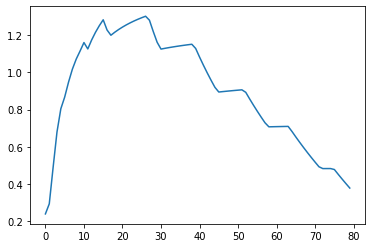

In [9]:
sol_test = SocketTesterBatchSOLUTIONProb(PowerSocketProb, rewards_bias, 10, 0)
rd = sol_test.run(decisions, 0.8, True)
plt.plot(rd["bias_hist"])

In [ ]:
sol_test = SocketTesterBatchSOLUTIONProb(PowerSocketProb, rewards_bias, 10, 0.25)
rd = sol_test.run(decisions, 0.8, True)
plt.plot(rd["bias_hist"])

In [ ]:
sol_test = SocketTesterBatchSOLUTIONProb(PowerSocketProb, rewards_bias, 10, 0.5)
rd = sol_test.run(decisions, 0.8, True)
plt.plot(rd["bias_hist"])

In [ ]:
sol_test = SocketTesterBatchSOLUTIONProb(PowerSocketProb, rewards_bias, 10, 0.75)
rd = sol_test.run(decisions, 0.8, True)
plt.plot(rd["bias_hist"])

In [ ]:
sol_test = SocketTesterBatchSOLUTIONProb(PowerSocketProb, rewards_bias, 10, 1)
rd = sol_test.run(decisions, 0.8, True)
plt.plot(rd["bias_hist"])

In [11]:
rwd_results = []
presence_results = []
rate_results = []
posteriors_results = []
decisions = random.choices(range(8),weights=list(instances_nonbias),k=1000)
for sopt in np.arange(0,1.1,0.1):
  sopt_i_rwd_results = []
  sopt_i_presence_results = []
  sopt_i_rate_results = []
  sopt_i_posteriors_results = []
  sol_test = SocketTesterBatchSOLUTIONProb(PowerSocketProb, rewards_bias, 10, sopt)
  for iter in range(25):
    rd = sol_test.run(decisions, 0.8, False)
    sopt_i_rwd_results.append(rd["total_reward"])
    sopt_i_presence_results.append(rd["bias_presence"])
    sopt_i_rate_results.append(rd["bias_rate"])
    sopt_i_posteriors_results.append(rd["bias_posteriors"])
  rwd_results.append([np.mean(sopt_i_rwd_results),np.std(sopt_i_rwd_results)])
  presence_results.append([np.mean(sopt_i_presence_results),np.std(sopt_i_presence_results)])
  rate_results.append([np.mean(sopt_i_rate_results),np.std(sopt_i_rate_results)])
  posteriors_results.append([np.mean(sopt_i_posteriors_results),np.std(sopt_i_posteriors_results)])
print([rwd_results[i][0] for i in range(len(rwd_results))])
print([presence_results[i][0] for i in range(len(presence_results))])

[62216.0, 62472.0, 62020.0, 62584.0, 62324.0, 61720.0, 62060.0, 61928.0, 61992.0, 61936.0, 61436.0]
[0.3777037702871411, 0.360718202247191, 0.3447378776529339, 0.360727290886392, 0.30506816479400745, 0.31588923845193506, 0.26436324594257177, 0.20554896379525592, 0.06379665418227214, 0.0025992509363295807, 0.0025992509363295807]


In [ ]:
#print([rwd_results[i][0] for i in range(len(rwd_results))])
#print([bias_results[i][0] for i in range(len(bias_results))])

In [12]:
import matplotlib.pyplot as plt
import numpy as np

xr = np.arange(0,1.1,0.1)
yr = [rwd_results[i][0] for i in range(len(rwd_results))]
er = [rwd_results[i][1] for i in range(len(rwd_results))]

xpres = np.arange(0,1.1,0.1)
ypres = [presence_results[i][0] for i in range(len(presence_results))]
epres = [presence_results[i][1] for i in range(len(presence_results))]

xrate = np.arange(0,1.1,0.1)
yrate = [rate_results[i][0] for i in range(len(rate_results))]
erate = [rate_results[i][1] for i in range(len(rate_results))]

xpost = np.arange(0,1.1,0.1)
ypost = [posteriors_results[i][0] for i in range(len(posteriors_results))]
epost = [posteriors_results[i][1] for i in range(len(posteriors_results))]

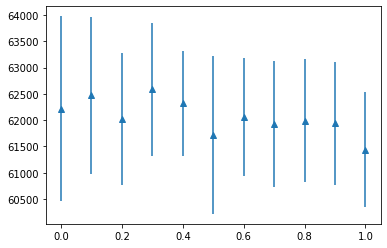

In [13]:
plt.errorbar(xr, yr, er, linestyle='None', marker='^')
plt.show() #total rewards (y) vs subopt value (x)

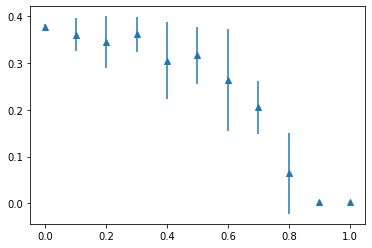

In [14]:
plt.errorbar(xpres, ypres, epres, linestyle='None', marker='^')
plt.show()  #final bias (y) vs subopt value (x)

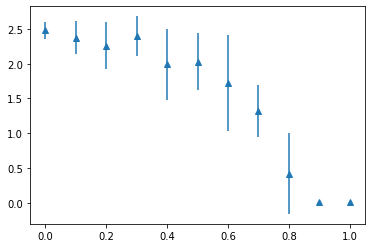

In [15]:
plt.errorbar(xrate, yrate, erate, linestyle='None', marker='^')
plt.show()  #final bias (y) vs subopt value (x)

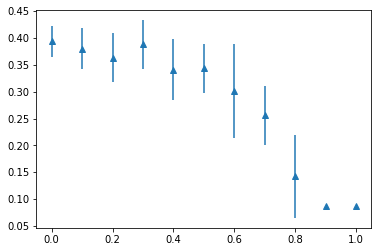

In [16]:
plt.errorbar(xpost, ypost, epost, linestyle='None', marker='^')
plt.show()  #final bias (y) vs subopt value (x)

In [ ]:
ma = np.mean([0,0,1,0])
mb = np.mean([0,0,1,1])
mc = np.mean([0,0,1,0,0,0,1,1])
md = (ma+mb)/2
print(ma,mb,mc,md)

In [ ]:
r_coef = 0.5
old_r_term = np.multiply([0.25],1-r_coef)
new_r_term = np.multiply([0.5],r_coef)
rewards_d = np.add(old_r_term,new_r_term)
rewards_d = np.clip(rewards_d,0,1)
print(rewards_d)

curr_percentages = self.socket_stats[:,:,1][t]/t
mean_percentages = np.mean(curr_percentages)
dif_percentages = np.subtract(mean_percentages,self.socket_stats[:,:,1][t]/t)

mean_selections = np.mean(self.get_number_of_trials()[t])
dif_selections = np.subtract(mean_selections,self.get_number_of_trials()[t])

#DUES CONSTRAINTS, UNA PER PERCENTATGES, L'ALTRE n SELECTIONS
//dif = dif_percentages #rang 10-30-50

dif = dif_selections   #rang 0-0.01-0.1

In [18]:
def nonstatic_sol(iter, rewards_d_o_mu, r_coef, instances_d_o, i_coef, sub_opt):
  rewards_d = np.array(rewards_d_o_mu)
  instances_d = np.array(instances_d_o)

  for i in range(iter):
    pbool=False
    if(i%math.ceil(iter/4)==0 or i==iter-1):
        print(i)
        pbool=True

    updated_test = SocketTesterBatchSOLUTIONProb(PowerSocketProb, list(rewards_d), 10, sub_opt)
    decisions = random.choices(range(8),weights=list(instances_d),k=1000)
    rd = updated_test.run(decisions, 0.8, pbool)

    r_update = rd["estimates"]
    i_update = rd["increments"]
    #print(i_update)
    old_r_term = np.multiply(rewards_d,1-r_coef)
    new_r_term = np.multiply(r_update,r_coef)
    rewards_d = np.add(old_r_term,new_r_term)
    rewards_d = np.clip(rewards_d,0,0.99)

    #print(instances_d, i_update, i_update*i_coef)
    old_i_term = np.multiply(instances_d,1-i_coef)
    new_i_term = np.multiply(np.multiply(instances_d,i_update),i_coef)
    instances_d = np.add(old_i_term,new_i_term)
    instances_d = np.clip(instances_d,0,None)
    instances_d = instances_d / instances_d.sum()

In [ ]:
nonstatic_sol(10, rewards_bias, 0.0, instances_nonbias, 0.0, 0)

In [ ]:
nonstatic_sol(10, rewards_bias, 0.0, instances_nonbias, 0.0, 1)

In [29]:
nonstatic_sol(50, rewards_bias, 0.5, instances_nonbias, 1, 0)

0
Reward distribution: [0.8555, 0.8193, 0.8284, 0.7994, 0.7103, 0.6635, 0.7471, 0.6731]
Final estimates: [0.8235, 0.822, 0.7833, 0.7903, 0.7162, 0.6216, 0.0, 0.678]
Presence of each in batch (%): [11.9, 11.8, 12.0, 12.4, 14.8, 11.1, 14.0, 12.0]
Relative approval rate (%): [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 0.71, 49.17]
Percentage over total selected (%): [14.86, 14.73, 14.98, 15.48, 18.48, 13.86, 0.12, 7.37]
Total reward: 60300 || and presence bias: 0.36893882646691634
Rate bias: 2.2517857142857145
Posteriors bias: 0.34956304619225964
13
Reward distribution: [0.706, 0.8399, 0.8593, 0.7474, 0.7712, 0.2936, 0.0109, 0.0067]
Final estimates: [0.7143, 0.875, 0.8824, 0.7452, 0.8065, 0.0, 0.0, 0.0]
Presence of each in batch (%): [16.1, 12.0, 20.4, 15.7, 16.0, 11.4, 3.9, 4.5]
Relative approval rate (%): [100.0, 100.0, 100.0, 100.0, 96.88, 0.88, 2.56, 2.22]
Percentage over total selected (%): [20.1, 14.98, 25.47, 19.6, 19.35, 0.12, 0.12, 0.12]
Total reward: 64300 || and presence bias: 0

In [30]:
nonstatic_sol(50, rewards_bias, 0.5, instances_nonbias, 1, 0.5)

0
Reward distribution: [0.8555, 0.8193, 0.8284, 0.7994, 0.7103, 0.6635, 0.7471, 0.6731]
Final estimates: [0.8485, 0.8231, 0.8467, 0.792, 0.6452, 0.0, 0.7719, 0.7287]
Presence of each in batch (%): [13.2, 13.0, 13.7, 12.5, 11.8, 11.5, 11.4, 12.9]
Relative approval rate (%): [100.0, 100.0, 100.0, 100.0, 26.27, 1.74, 100.0, 100.0]
Percentage over total selected (%): [16.48, 16.23, 17.1, 15.61, 3.87, 0.25, 14.23, 16.1]
Total reward: 63700 || and presence bias: 0.38235455680399494
Rate bias: 2.5798452468680915
Posteriors bias: 0.4169787765293383
13
Reward distribution: [0.7981, 0.8412, 0.8451, 0.78, 0.0016, 0.0016, 0.6773, 0.6072]
Final estimates: [0.7874, 0.7917, 0.8556, 0.7929, 0.0, 0.0, 0.4, 0.5942]
Presence of each in batch (%): [12.7, 16.8, 18.7, 16.9, 4.5, 4.7, 11.9, 13.8]
Relative approval rate (%): [100.0, 100.0, 100.0, 100.0, 6.67, 6.38, 4.2, 100.0]
Percentage over total selected (%): [15.86, 20.97, 23.35, 21.1, 0.37, 0.37, 0.62, 17.23]
Total reward: 61200 || and presence bias: 0.3

In [31]:
nonstatic_sol(50, rewards_bias, 0.5, instances_nonbias, 1, 1)

0
Reward distribution: [0.8555, 0.8193, 0.8284, 0.7994, 0.7103, 0.6635, 0.7471, 0.6731]
Final estimates: [0.8304, 0.8384, 0.8, 0.75, 0.7075, 0.63, 0.84, 0.6436]
Presence of each in batch (%): [14.0, 12.4, 11.2, 11.5, 13.2, 12.5, 12.5, 12.7]
Relative approval rate (%): [80.0, 79.84, 80.36, 80.0, 80.3, 80.0, 80.0, 79.53]
Percentage over total selected (%): [13.98, 12.36, 11.24, 11.49, 13.23, 12.48, 12.48, 12.61]
Total reward: 60500 || and presence bias: 0.002636704119850175
Rate bias: 0.013071253739909916
Posteriors bias: 0.04744069912609242
13
Reward distribution: [0.8604, 0.7936, 0.8021, 0.8119, 0.7758, 0.7348, 0.7184, 0.6762]
Final estimates: [0.8471, 0.7813, 0.7767, 0.7981, 0.8511, 0.7431, 0.74, 0.6514]
Presence of each in batch (%): [10.7, 12.0, 12.9, 13.0, 11.7, 13.6, 12.5, 13.6]
Relative approval rate (%): [79.44, 80.0, 79.84, 80.0, 80.34, 80.15, 80.0, 80.15]
Percentage over total selected (%): [10.61, 11.99, 12.86, 12.98, 11.74, 13.61, 12.48, 13.61]
Total reward: 61700 || and pre

In [ ]:
variances = [10]*8
##(5000 per iter)
nonstatic_sol(1000, rewards_bias, 0.02, instances_bias, 0.02, 0.1, variances)

In [ ]:
variances = [10]*8
nonstatic_sol(1000, rewards_bias, 0.04, instances_bias, 0.04, 100, variances)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
import pandas as pd
import numpy as np

from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)
drive.mount(ROOT)

unpickled_df = pd.read_csv("/content/drive/MyDrive/TFG/hmda/state_AL-GA_actions_taken_1-3.csv")
print(unpickled_df.derived_sex.unique(),'\n',
unpickled_df.derived_race.unique(),'\n',
unpickled_df.derived_ethnicity.unique(),'\n',
unpickled_df.action_taken.unique())

subsample = unpickled_df                    

print(len(subsample.loc[subsample["action_taken"]==1]),len(subsample.loc[subsample["action_taken"]==3]))
subsample = subsample.loc[subsample["action_taken"].isin([1,3])]
subsample["action_taken"] = subsample["action_taken"].replace([3],[0])    
print("action:",subsample["action_taken"].unique())
print(len(subsample.loc[subsample["action_taken"]==1]),len(subsample.loc[subsample["action_taken"]==0]))

print("race pre:",subsample["derived_race"].unique())
subsample = subsample.loc[subsample["derived_race"].isin(["White","Black or African American"])]
subsample["derived_race"] = subsample["derived_race"].replace(["White","Black or African American"],[0,1])
print("race:",subsample["derived_race"].unique())

print("ethnicity pre:",subsample["derived_ethnicity"].unique())
subsample = subsample.loc[subsample["derived_ethnicity"].isin(['Not Hispanic or Latino','Hispanic or Latino'])]
subsample["derived_ethnicity"] = subsample["derived_ethnicity"].replace(['Not Hispanic or Latino','Hispanic or Latino'],[0,1])
print("ethnicity:",subsample["derived_ethnicity"].unique())

print("sex pre",subsample["derived_sex"].unique())
subsample = subsample.loc[subsample["derived_sex"].isin(['Male','Female'])]
subsample["derived_sex"] = subsample["derived_sex"].replace(['Male','Female'],[0,1])
print("sex:",subsample["derived_sex"].unique())


subsample = subsample.loc[subsample["interest_rate"]!='Exempt']
subsample["interest_rate"] = pd.to_numeric(subsample["interest_rate"] ) 

#print(len(subsample.loc[subsample["loan_to_value_ratio"]=='Exempt']))
subsample = subsample.loc[subsample["loan_to_value_ratio"]!='Exempt']
#print(len(subsample.loc[subsample["loan_to_value_ratio"]=='Exempt']))
#print(subsample["loan_to_value_ratio"])
subsample["loan_to_value_ratio"] = pd.to_numeric(subsample["loan_to_value_ratio"] )  
#print(subsample["loan_to_value_ratio"].mean())

subsample = subsample.loc[subsample["property_value"]!='Exempt']
subsample["property_value"] = pd.to_numeric(subsample["property_value"] ) 

print(len(subsample.loc[subsample["action_taken"]==1]),len(subsample.loc[subsample["action_taken"]==0]))

print(len(subsample))
#subsample = subsample[["loan_type", "property_type", "loan_purpose", "loan_amount_000s",
#                            "action_taken","applicant_ethnicity","applicant_race_1","applicant_sex",
#                           "applicant_income_000s"]]
print(len(subsample.loc[subsample["action_taken"]==1]),len(subsample.loc[subsample["action_taken"]==0]))
print(len(subsample),len(subsample.columns),subsample.isnull().values.sum())

#thr=0.25
#for col in subsample.columns:
#  if (subsample[col].isnull().sum()>thr*len(subsample)):
    #subsample.drop(columns=[col])
#    print(col)

#subsample = subsample.dropna(axis=1,thresh=thr*len(subsample))
#subsample = subsample.dropna(axis=0)

# Iterate over each column of cc_apps
for col in subsample.columns:
    # Check if the column is of object type
    if subsample[col].dtypes == 'object':
        # Impute with the most frequent value
        subsample = subsample.fillna(subsample[col].value_counts().index[0])


print(len(subsample.loc[subsample["action_taken"]==1]),len(subsample.loc[subsample["action_taken"]==0]))

# Count the number of NaNs in the dataset and print the counts to verify
print(len(subsample),len(subsample.columns),subsample.isnull().values.sum())
cols = [f_ for f_ in subsample.columns if subsample[f_].dtype != 'object']
features = cols

list_to_remove = ['action_taken','purchaser_type', 'activity_year',
                  'denial_reason_1','denial_reason_2','denial_reason_3','sequence_number','application_date_indicator']

features = list(set(cols).difference(set(list_to_remove)))

X = subsample[features]
y = subsample['action_taken']

# Import train_test_split
from sklearn.model_selection import train_test_split
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                y,
                                test_size=0.3,
                                random_state=2)

X_test1, X_test2, y_test1, y_test2 = train_test_split(X_test,
                                y_test,
                                test_size=0.33,
                                random_state=2)

scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX = scaler.fit_transform(X)
rescaledX_train = scaler.fit_transform(X_train)
rescaledX_test = scaler.fit_transform(X_test)
rescaledX_test1 = scaler.fit_transform(X_test1)
rescaledX_test2 = scaler.fit_transform(X_test2)

logreg = LogisticRegression(solver="liblinear")

scores_dict = cross_validate(logreg,rescaledX_train,y_train,cv=5, return_estimator=True)
best = scores_dict["estimator"][0] 


y_pred = best.predict(rescaledX_test1)
from collections import Counter
counterpred = Counter(y_pred)
countertest = Counter(y_test1)
counterall = Counter(y)
print(counterpred, countertest, counterall)
print("Accuracy of logistic regression classifier: ", best.score(rescaledX_test1, y_test1))


y_pred = best.predict(rescaledX_test2)
counterpred = Counter(y_pred)
countertest = Counter(y_test2)
counterall = Counter(y)
print(counterpred, countertest, counterall)
print("Accuracy of logistic regression classifier: ", best.score(rescaledX_test2, y_test2))

In [ ]:
import math
def partitions(n_partitions, X, y):
  X_partitions = []
  y_partitions = []
  size_partitions = math.floor(len(X)/n_partitions)
  for p in range(n_partitions):
    X_partitions.append(X[p*size_partitions:(p+1)*size_partitions])  
    y_partitions.append(y[p*size_partitions:(p+1)*size_partitions])
  print(len(X), [sum(len(item) for item in X_partitions)], len(X_partitions[0]))
  return X_partitions, y_partitions

In [ ]:
def create_df(x,xcol,y,ycol):
  auxnparray = x.copy()
  newdf = pd.DataFrame(auxnparray, columns = xcol)
  newdf[ycol] = y.tolist()
  return newdf

In [ ]:
def preproc(df):
  subgroups = []
  instances = []
  sensitive = ["derived_race","derived_ethnicity","derived_sex"]
  R = ["W","B"]
  E = ["NH","H"]
  S = ["M","F"]
  for option in [0,1]:
    for option2 in [0,1]:
      for option3 in [0,1]:
          subgroups.append(df.loc[((df[sensitive[0]]==option) & (df[sensitive[1]]==option2) & (df[sensitive[2]]==option3))])
          instances.append(len(subgroups[-1]))
  return subgroups, instances

In [ ]:
from scipy.stats import norm

df = create_df(X,features,y,"action_taken")

mean1, std1 = norm.fit(df.loc[df["action_taken"]==1.0]["loan_amount"])

mean0, std0 = norm.fit(df.loc[df["action_taken"]==0.0]["loan_amount"])

print(mean1, std1)
print(mean0, std0)
print()
sg, ic = preproc(df)
for s in sg:
  approval_rate = len(s.loc[s["action_taken"]==1.0])/len(s)
  print(approval_rate)
  mu, std = norm.fit(s["loan_amount"])
  print(mu,std)

In [ ]:
class PowerSocketReal:
    """ the base power socket class """
    
    def __init__(self, q, cl, var=1):                
        self.q = q        # the true reward value 
        self.confidence_level = cl          
        self.var = var   
        self.initialize() # reset the socket
        
    def initialize(self):
        self.Q = 0   # the estimate of this socket's reward value                
        self.n = 0   # the number of times this socket has been tried        
    
    def charge(self):
        """ return a random amount of charge """
        
        # the reward is a guassian distribution with unit variance around the true
        # value 'q'
        # value = self.var * np.random.randn() + self.q      

        #value = self.q.iloc[self.n]["action_taken"]

        #value = self.q["action_taken"].sample(n=1).iloc[0]

        sample = self.q.sample(n=1)
        if (sample["action_taken"].iloc[0]==1.0):
          value = sample["loan_amount"].iloc[0]
        else:
          value = 0.0

        # never allow a charge less than 0 to be returned        
        return 0 if value < 0 else value
               
    def update(self,R):
        """ update this socket after it has returned reward value 'R' """     
    
        # increment the number of times this socket has been tried
        self.n += 1

        # the new estimate of the mean is calculated from the old estimate
        self.Q = (1 - 1.0/self.n) * self.Q + (1.0/self.n) * R

    def uncertainty(self, t): 
        """ calculate the uncertainty in the estimate of this socket's mean """
        if self.n == 0: return float('inf')                         
        return self.confidence_level * (np.sqrt(np.log(t) / self.n))         
        
    def sample(self,t):
        """ the UCB reward is the estimate of the mean reward plus its uncertainty """
        return self.Q + self.uncertainty(t) 

In [ ]:
class SocketTesterBatchReal():
    """ create and test a set of sockets over a single test run """

    def __init__(self, socket, socket_order, confidence_level):  
        
        # create supplied socket type with a mean value defined by socket order 
        self.sockets = [socket(q, confidence_level) for q in socket_order]     
        
        # set the number of sockets equal to the number created
        self.number_of_sockets = len(self.sockets)

        self.number_of_stats = 2                 
            
    def initialize_run(self, number_of_steps):
        """ reset counters at the start of a run """
        
        # save the number of steps over which the run will take place
        self.number_of_steps = number_of_steps
        
        # reset the actual number of steps that the test ran for
        self.total_steps = 0
        
        # monitor the total reward obtained over the run
        self.total_reward = 0
        
        # the current total reward at each timestep of the run
        self.total_reward_per_timestep = []
        
        # the actual reward obtained at each timestep
        self.reward_per_timestep = []
           
        # stats for each time-step
        # - by default records: estimate, number of trials
        self.socket_stats = np.zeros(shape=(number_of_steps+1, 
                                            self.number_of_sockets, 
                                            self.number_of_stats))
        
        # ensure that all sockets are re-initialized
        for socket in self.sockets: socket.initialize()
            
                                
    def charge_and_update(self,socket_index):
        """ charge from & update the specified socket and associated parameters """
        
        # charge from the chosen socket and update its mean reward value
        reward = self.sockets[socket_index].charge()
        self.sockets[socket_index].update(reward)

        # update the total reward
        self.total_reward += reward   
        
        # store the current total reward at this timestep
        self.total_reward_per_timestep.append(self.total_reward)
        
        # store the reward obtained at this timestep
        self.reward_per_timestep.append(reward)        
        
        
    def get_socket_stats( self, t ):
        """ get the current information from each socket """        
        socket_stats = [[socket.Q, socket.n] for socket in self.sockets]
        return socket_stats     
    
    def get_mean_reward( self ):
        """ the total reward averaged over the number of time steps """
        return (self.total_reward/self.total_steps)
    
    def get_total_reward_per_timestep( self ):
        """ the cumulative total reward at each timestep of the run """
        return self.total_reward_per_timestep
    
    def get_reward_per_timestep( self ):
        """ the actual reward obtained at each timestep of the run """
        return self.reward_per_timestep
    
    def get_estimates(self):
        """ get the estimate of each socket's reward at each timestep of the run """
        return self.socket_stats[:,:,0]  
    
    def get_number_of_trials(self):
        """ get the number of trials of each socket at each timestep of the run """
        return self.socket_stats[:,:,1]          
                
    def get_socket_percentages( self ):
        """ get the percentage of times each socket was tried over the run """
        return (self.socket_stats[:,:,1][self.total_steps]/self.total_steps)        
    
    def get_time_steps( self ):
        """ get the number of time steps that the test ran for """
        return self.total_steps
    
    def select_socket( self, t ):
        """ Greedy Socket Selection"""
        
        # choose the socket with the current highest mean reward or arbitrarily
        # select a socket in the case of a tie            
        mask = [self.get_number_of_trials()[t][i]<self.possibles[i] for i in range(len(self.sockets))]
        #print(mask)
        available = [self.sockets[i] for i in range(len(self.sockets)) if (mask[i])]
        #print([socket.sample(t+1) for socket in available])
        socket_max = random_argmax([socket.sample(t+1) for socket in available]) 
        #print(socket_max)
        socket_index = self.sockets.index(available[socket_max])
        return socket_index     
    
    def return_increments(self, decisions_to_consider):
        presence = np.array([i/len(decisions_to_consider) for i in self.possibles])
        selected_presence = np.array(self.get_socket_percentages())
        diff = np.subtract(selected_presence, presence)
        #print(diff)
        #print(diff.sum())
        return diff
    
    def run( self, decisions_to_consider, class_count, max_percent_decisions=1, prints_bool = True):  
        """ perform a single run, over the set of sockets, 
            for the defined number of steps """
        
        for s in range(len(self.sockets)):
          self.sockets[s].q = decisions_to_consider[s]     

        # reset the run counters
        self.initialize_run(sum(class_count))

        self.possibles = class_count
        print(self.possibles)

        usos = 0
        usos_maxims = math.floor(max_percent_decisions*sum(class_count))
        #print(usos_maxims)

        # loop for the specified number of time-steps
        for t in range(sum(class_count)):

            # get information about all sockets at the start of the time step
            self.socket_stats[t] = self.get_socket_stats(t)            
            
            # select a socket
            socket_index = self.select_socket(t)
            #if(decisions_to_consider[t]==socket_index):
            if(self.get_number_of_trials()[t][socket_index]<self.possibles[socket_index]):
              # charge from the chosen socket and update its mean reward value
              self.charge_and_update(socket_index)
              usos+=1
              
              if usos > usos_maxims:
                  #print(usos,usos_maxims)
                  break
        # save the actual number of steps that have been run
        self.total_steps = t    
    
        # get the stats for each socket at the end of the run        
        self.socket_stats[t+1] = self.get_socket_stats(t+1)           
        
        if(prints_bool):
          #print("Reward distribution:",[s.q for s in self.sockets])
          #print("Intances of each cluster:",self.possibles)
          print("Presence of each in batch (%):",[100*i/sum(class_count) for i in self.possibles])
          #print("Times selected:",self.get_number_of_trials()[t])
          print("Relative approval rate (%):",[round(100*self.get_number_of_trials()[t][i]/self.possibles[i],2) if self.possibles[i]>0.0 else 0.0 for i in range(len(self.possibles))])
          print("Percentage over total selected (%):",[round(100*p,2) for p in self.get_socket_percentages()])
          #print("For a total reward:",self.total_reward)


        return self.total_steps, self.total_reward, self.return_increments(decisions_to_consider)

In [ ]:
class SocketTesterBatchRealBudget():
    """ create and test a set of sockets over a single test run """

    def __init__(self, socket, socket_order, confidence_level):  
        
        # create supplied socket type with a mean value defined by socket order 
        self.sockets = [socket(q, confidence_level) for q in socket_order]     
        
        # set the number of sockets equal to the number created
        self.number_of_sockets = len(self.sockets)

        self.number_of_stats = 2                 
            
    def initialize_run(self, number_of_steps):
        """ reset counters at the start of a run """
        
        # save the number of steps over which the run will take place
        self.number_of_steps = number_of_steps
        
        # reset the actual number of steps that the test ran for
        self.total_steps = 0
        
        # monitor the total reward obtained over the run
        self.total_reward = 0
        
        # the current total reward at each timestep of the run
        self.total_reward_per_timestep = []
        
        # the actual reward obtained at each timestep
        self.reward_per_timestep = []
           
        # stats for each time-step
        # - by default records: estimate, number of trials
        self.socket_stats = np.zeros(shape=(number_of_steps+1, 
                                            self.number_of_sockets, 
                                            self.number_of_stats))
        
        # ensure that all sockets are re-initialized
        for socket in self.sockets: socket.initialize()
            
                                
    def charge_and_update(self,socket_index):
        """ charge from & update the specified socket and associated parameters """
        
        # charge from the chosen socket and update its mean reward value
        reward = self.sockets[socket_index].charge()
        self.sockets[socket_index].update(reward)

        # update the total reward
        self.total_reward += reward  
        self.budget -= reward 
        
        # store the current total reward at this timestep
        self.total_reward_per_timestep.append(self.total_reward)
        
        # store the reward obtained at this timestep
        self.reward_per_timestep.append(reward)        
        
        
    def get_socket_stats( self, t ):
        """ get the current information from each socket """        
        socket_stats = [[socket.Q, socket.n] for socket in self.sockets]
        return socket_stats     
    
    def get_mean_reward( self ):
        """ the total reward averaged over the number of time steps """
        return (self.total_reward/self.total_steps)
    
    def get_total_reward_per_timestep( self ):
        """ the cumulative total reward at each timestep of the run """
        return self.total_reward_per_timestep
    
    def get_reward_per_timestep( self ):
        """ the actual reward obtained at each timestep of the run """
        return self.reward_per_timestep
    
    def get_estimates(self):
        """ get the estimate of each socket's reward at each timestep of the run """
        return self.socket_stats[:,:,0]  
    
    def get_number_of_trials(self):
        """ get the number of trials of each socket at each timestep of the run """
        return self.socket_stats[:,:,1]          
                
    def get_socket_percentages( self ):
        """ get the percentage of times each socket was tried over the run """
        return (self.socket_stats[:,:,1][self.total_steps]/self.total_steps)        
    
    def get_time_steps( self ):
        """ get the number of time steps that the test ran for """
        return self.total_steps
    
    def select_socket( self, t ):
        """ Greedy Socket Selection"""
        
        # choose the socket with the current highest mean reward or arbitrarily
        # select a socket in the case of a tie            
        mask = [self.get_number_of_trials()[t][i]<self.possibles[i] for i in range(len(self.sockets))]
        #print(mask)
        available = [self.sockets[i] for i in range(len(self.sockets)) if (mask[i])]
        #print([socket.sample(t+1) for socket in available])
        socket_max = random_argmax([socket.sample(t+1) for socket in available]) 
        #print(socket_max)
        socket_index = self.sockets.index(available[socket_max])
        return socket_index     
    
    def return_increments(self, decisions_to_consider):
        presence = np.array([i/len(decisions_to_consider) for i in self.possibles])
        selected_presence = np.array(self.get_socket_percentages())
        diff = np.subtract(selected_presence, presence)
        #print(diff)
        #print(diff.sum())
        return diff
    
    def run( self, decisions_to_consider, class_count, budget, prints_bool = True):  
        """ perform a single run, over the set of sockets, 
            for the defined number of steps """
        
        for s in range(len(self.sockets)):
          self.sockets[s].q = decisions_to_consider[s]     

        # reset the run counters
        self.initialize_run(sum(class_count))

        self.possibles = class_count
        print(self.possibles)

        usos = 0
        self.budget = budget
        #print(usos_maxims)

        # loop for the specified number of time-steps
        for t in range(sum(class_count)):

            # get information about all sockets at the start of the time step
            self.socket_stats[t] = self.get_socket_stats(t)            
            
            # select a socket
            socket_index = self.select_socket(t)
            #if(decisions_to_consider[t]==socket_index):
            if(self.get_number_of_trials()[t][socket_index]<self.possibles[socket_index]):
              # charge from the chosen socket and update its mean reward value
              self.charge_and_update(socket_index)
              usos+=1
            if self.budget-max(self.get_estimates()[t]) < 0:
              break
        # save the actual number of steps that have been run
        self.total_steps = t    
    
        # get the stats for each socket at the end of the run        
        self.socket_stats[t+1] = self.get_socket_stats(t+1)           
        
        if(prints_bool):
          #print("Reward distribution:",[s.q for s in self.sockets])
          #print("Intances of each cluster:",self.possibles)
          print("Presence of each in batch (%):",[100*i/sum(class_count) for i in self.possibles])
          #print("Times selected:",self.get_number_of_trials()[t])
          print("Relative approval rate (%):",[round(100*self.get_number_of_trials()[t][i]/self.possibles[i],2) if self.possibles[i]>0.0 else 0.0 for i in range(len(self.possibles))])
          print("Percentage over total selected (%):",[round(100*p,2) for p in self.get_socket_percentages()])
          #print("For a total reward:",self.total_reward)


        return self.total_steps, self.total_reward, self.return_increments(decisions_to_consider)

In [ ]:
real_test = SocketTesterBatchReal(PowerSocketReal, [[0]]*8, 5)
print(real_test.sockets)


X_p, y_p = partitions(4,X,y)
for b in range(4):
  batch = create_df(X_p[b],features,y_p[b],"action_taken")
  sg, ic = preproc(batch)
  ts,tr,ti = real_test.run(sg, ic, 0.8, True)

In [ ]:
real_test = SocketTesterBatchRealBudget(PowerSocketReal, [[0]]*8, 5)
print(real_test.sockets)


X_p, y_p = partitions(10,X,y)
for b in range(10):
  batch = create_df(X_p[b],features,y_p[b],"action_taken")
  budget = batch["loan_amount"].sum()
  sg, ic = preproc(batch)
  ts,tr,ti = real_test.run(sg, ic, 0.8*budget, True)

In [ ]:
real_test = SocketTesterBatchRealBudget(PowerSocketReal, [[0]]*8, 5)
print(real_test.sockets)


X_p, y_p = partitions(1,X,y)
for b in range(1):
  batch = create_df(X_p[b],features,y_p[b],"action_taken")
  #budget = batch["loan_amount"].sum()
  budget=0
  sg, ic = preproc(batch)
  min_amount = min(ic)
  for s in range(len(sg)):
    sg[s] = sg[s].sample(n=min_amount)
    budget += sg[s]["loan_amount"].sum()
  ts,tr,ti = real_test.run(sg, [min_amount]*8, 0.8*budget, True)